In [9]:
%reload_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchcps.kernel import GaussianKernel
from torchcps.kernel_cnn import KernelConv, KernelPool, KernelMap

In [11]:
# create a datset of 2D signals with noise
n_samples = 10000
n_dimensions = 2
n_measurements = 10

with torch.no_grad():
    targets = 50 * torch.rand(n_samples, n_dimensions) - 25
    # convert to polar coordinates
    targets_range = torch.norm(targets, dim=-1)
    targets_bearing = torch.atan2(targets[..., 1], targets[..., 0])
    # add noise to make measurements
    measurements_range = (
        targets_range[..., None] + torch.randn(n_samples, n_measurements) * 1.0
    )
    measurements_bearing = (
        targets_bearing[..., None] + torch.randn(n_samples, n_measurements) * 0.5
    )
    # convert back to cartesian coordinates
    measurements = torch.stack(
        [
            measurements_range * torch.cos(measurements_bearing),
            measurements_range * torch.sin(measurements_bearing),
        ],
        dim=-1,
    )

In [12]:
# evaluate naive strategy of taking mean of measurements
input_mean = measurements.mean(dim=1)
(input_mean - targets).pow(2).mean()

tensor(7.6462)

In [13]:
class UnpackTuple(nn.Module):
    def forward(self, input):
        return input[0], input[1]


n_channels = 1
max_kernels = 16
filter_kernels = 9
fixed_positions = False
kernel_size = 5.0
pool_strategy = "largest"


model_factory = lambda: nn.Sequential(
    UnpackTuple(),
    KernelConv(
        filter_kernels=filter_kernels,
        in_channels=1,
        out_channels=n_channels,
        n_dimensions=2,
        kernel_spread=kernel_size,
        fixed_positions=fixed_positions,
    ),
    KernelPool(
        max_kernels,
        GaussianKernel(kernel_size),
        nn.ReLU(),
        strategy=pool_strategy,
    ),
    KernelConv(
        filter_kernels=filter_kernels,
        in_channels=n_channels,
        out_channels=n_channels,
        n_dimensions=2,
        kernel_spread=kernel_size * 2,
        fixed_positions=fixed_positions,
    ),
    KernelPool(
        max_kernels,
        GaussianKernel(kernel_size * 2),
        nn.ReLU(),
        strategy=pool_strategy,
    ),
    KernelConv(
        filter_kernels=filter_kernels,
        in_channels=n_channels,
        out_channels=1,
        n_dimensions=2,
        kernel_spread=kernel_size * 4,
        fixed_positions=fixed_positions,
    ),
    KernelPool(
        max_kernels,
        GaussianKernel(kernel_size * 4),
        nn.ReLU(),
        strategy=pool_strategy,
    ),
).cuda()

In [14]:
from torch.optim import AdamW
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(measurements.cuda(), targets.cuda())
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

model = model_factory()
optimizer = AdamW(model.parameters(), lr=1e-2, weight_decay=0)
mse_values = []

pbar = tqdm(dataloader, total=len(dataloader), position=1, leave=False)
for x, y in pbar:
    x = x[:, None, ...]
    y = y[:, None, None, :]

    x_weights = torch.ones(*x.shape[:-1], device="cuda")
    y_weights = torch.ones(*y.shape[:-1], device="cuda")
    z, z_weights = model((x, x_weights))

    kernel = GaussianKernel(kernel_size)
    mse = kernel.squared_error(y, y_weights, z, z_weights).mean(0).sum()

    mse_values.append(mse.item())
    pbar.set_postfix(loss=mse.item())

    mse.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/625 [00:00<?, ?it/s]

1.0


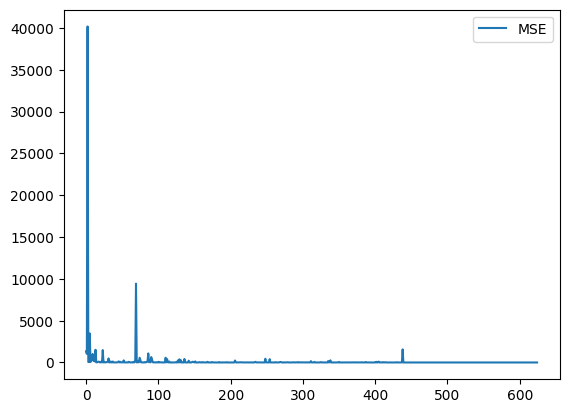

In [15]:
print(np.mean(mse_values[-10:]))

plt.figure()
plt.plot(mse_values, label="MSE")
plt.legend()
plt.show()

In [16]:
idx = np.random.randint(0, n_samples)

with torch.no_grad():
    x = measurements[None, idx, None, ...].cuda()
    y = targets[None, idx, None, None, :].cuda()
    x_weights = torch.ones(*x.shape[:-1], device=x.device)
    y_weights = torch.ones(*y.shape[:-1], device=y.device)

    z, z_weights = model((x, x_weights))

    # squeeze all the tensors
    x = x.squeeze().cpu()
    y = y.squeeze().cpu()
    z = z.squeeze().cpu()
    z_weights = z_weights.squeeze().cpu()

    extent = [-50, 50, -50, 50]
    # extent = [y[0].item() - 10, y[0].item() + 10, y[1].item() - 10, y[1].item() + 10]
    XY = torch.stack(
        torch.meshgrid(
            [
                torch.linspace(-extent[0], extent[1], 100),
                torch.linspace(-extent[0], extent[1], 100),
            ]
        ),
        -1,
    ).reshape(-1, 2)
    kernel = GaussianKernel(kernel_size)
    values = kernel(XY, z) @ z_weights
    values = values.reshape(100, 100).cpu().numpy()

    # naive way to make predictions
    input_mean = x.mean(0)
    # weigted mean of the cnn output
    output_mean = (z * z_weights[:, None]).sum(0) / z_weights.sum()

plt.figure()
plt.imshow(values.T, extent=extent, origin="lower")

plt.plot(*x.T, ".", label="Measurements")
plt.plot(*input_mean, "o", label="Mean of Measurements")
plt.plot(*output_mean, "o", label="Mean of CNN output")
plt.plot(*y, "x", label="Target")

plt.legend()
plt.colorbar()
plt.show()

NameError: name 'self' is not defined